In [1]:
import os
import numpy as np
import pandas as pd
from astropy.table import Table

# define environment before importing any DRP related modules
os.environ["LVMCORE_DIR"] = "/Users/droryn/prog/lvm/lvmcore"
os.environ["LVM_MASTER_DIR"] = "/Users/droryn/work/LVM/data/calib"
os.environ["SAS_BASE_DIR"] = "/Users/droryn/work/LVM/data/sas"
os.environ["LVM_DATA_S"] = "/Users/droryn/work/LVM/data/sas/sdsswork/data/lvm/lco"
os.environ["LVM_SPECTRO_REDUX"] = "/Users/droryn/work/LVM/data/redux"
ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")

from lvmdrp import path, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp
from lvmdrp.functions import run_quickdrp as qdrp

from lvmdrp.functions import imageMethod

MASTER_CON_LAMPS = {"b": "ldls", "r": "ldls", "z": "quartz"}
MASTER_ARC_LAMPS = {"b": "hgne", "r": "neon", "z": "neon"}
SLITMAP = Table(drp.fibermap.data)

In [2]:
MJD = 60171
print(ORIG_MASTER_DIR)

/Users/droryn/work/LVM/data/calib


In [15]:
drp.get_frames_metadata(mjd=MJD, overwrite=True)

[INFO]: Creating new metadata store.
[INFO]: going to extract metadata from 189 frames
extracting metadata: 100%|##########| 189/189 [00:32<00:00,  5.77frame/s]
[INFO]: creating metadata store at /Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60171/raw_metadata.hdf5
[INFO]: creating metadata store for tileid = 1111 and mjd = 60171 with 189 new rows
[INFO]: writing raw metadata store to disk
[INFO]: loading metadata store at /Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60171/raw_metadata.hdf5
[INFO]: updating metadata store for tileid = 1111 and mjd = 60171 with 0 new rows
[INFO]: final number of rows 189
[INFO]: writing raw metadata store to disk


,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,xenon,argon,ldls,quartz,quality,qual,stage,status,drpqual,name
0,s,1111,60171,60171,dark,sp2,r2,3109,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r2-00003109.fits
1,s,1111,60171,60171,dark,sp1,r1,3098,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r1-00003098.fits
2,s,1111,60171,60171,dark,sp2,z2,3098,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z2-00003098.fits
3,s,1111,60171,60171,dark,sp1,z1,3109,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z1-00003109.fits
4,s,1111,60171,60171,dark,sp3,b3,3099,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b3-00003099.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,s,1111,60171,60171,dark,sp2,z2,3111,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z2-00003111.fits
185,s,1111,60171,60171,dark,sp3,r3,3116,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r3-00003116.fits
186,s,1111,60171,60171,dark,sp3,r3,3106,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r3-00003106.fits
187,s,1111,60171,60171,dark,sp1,r1,3111,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r1-00003111.fits


In [16]:
frames_table = md.get_metadata(tileid="*", mjd=MJD)
frames_table.query("imagetyp == 'dark'", inplace=True)
frames_table.sort_values("camera", inplace=True)
frames_table = frames_table.loc[frames_table.name.str.contains("sdR")]
frames_table

[INFO]: loading metadata store at /Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60171/raw_metadata.hdf5
[INFO]: found 189 frames in store '/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60171/raw_metadata.hdf5'
[INFO]: number of frames after filtering 189
[INFO]: total number of frames found 189


,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,xenon,argon,ldls,quartz,quality,qual,stage,status,drpqual,name
110,s,1111,60171,60171,dark,sp1,b1,3115,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b1-00003115.fits
114,s,1111,60171,60171,dark,sp1,b1,3099,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b1-00003099.fits
127,s,1111,60171,60171,dark,sp1,b1,3114,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b1-00003114.fits
58,s,1111,60171,60171,dark,sp1,b1,3108,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b1-00003108.fits
128,s,1111,60171,60171,dark,sp1,b1,3104,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b1-00003104.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,s,1111,60171,60171,dark,sp3,z3,3113,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z3-00003113.fits
115,s,1111,60171,60171,dark,sp3,z3,3109,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z3-00003109.fits
138,s,1111,60171,60171,dark,sp3,z3,3101,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z3-00003101.fits
86,s,1111,60171,60171,dark,sp3,z3,3115,5.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z3-00003115.fits


In [4]:
#os.listdir(ORIG_MASTER_DIR)
masters_mjd = qdrp.get_master_mjd(MJD)
masters_path = os.path.join(ORIG_MASTER_DIR, f"{masters_mjd}")
print(masters_path)

/Users/droryn/work/LVM/data/calib/60142


In [25]:
# define target folder for detrended pixelflats
target_dir = "/Users/droryn/work/LVM/data/redux/pixflats"
os.makedirs(target_dir, exist_ok=True)

dflat_paths = []
for pixflat in frames_table.to_dict("records"):
    flat_path = path.full("lvm_raw", camspec=pixflat["camera"], **pixflat)
    # print(flat_path)
    
    # output path
    cam = pixflat["camera"]
    exp = pixflat["expnum"]
    dflat_path = os.path.join(target_dir, f"lvm-dpixflat-{cam}-{exp}.fits")
    dflat_paths.append(dflat_path)
    
    # calib paths
    mbias_path = os.path.join(masters_path, f"lvm-mbias-{cam}.fits")
    
    imageMethod.preproc_raw_frame(in_image=flat_path, out_image=dflat_path, replace_with_nan=False)
    imageMethod.detrend_frame(in_image=dflat_path, out_image=dflat_path, in_bias=mbias_path, reject_cr=False, replace_with_nan=False)


[INFO]: starting preprocessing of raw image 'sdR-s-b1-00003120.fits.gz'


[INFO]: using header IMAGETYP = 'dark'
[INFO]: exposure time 100.0 (s)
[INFO]: using header TRIMSEC = ['[1:2043, 2041:4080]', '[2078:4120, 2041:4080]', '[1:2043, 1:2040]', '[2078:4120, 1:2040]']
[INFO]: using header BIASSEC = ['[2044:2060, 2041:4080]', '[2061:2077, 2041:4080]', '[2044:2060, 1:2040]', '[2061:2077, 1:2040]']
[INFO]: using header GAIN = [2.71, 2.71, 2.68, 2.69] (e-/ADU)
[INFO]: median and standard deviation in OS quadrant 1: 984.00 +/- 45.51 (ADU)
[INFO]: median and standard deviation in OS quadrant 2: 990.00 +/- 43.34 (ADU)
[INFO]: median and standard deviation in OS quadrant 3: 995.00 +/- 40.64 (ADU)
[INFO]: median and standard deviation in OS quadrant 4: 994.00 +/- 39.63 (ADU)
[INFO]: using header RDNOISE = [3.0, 3.0, 2.8, 2.8] (e-)
[INFO]: flipping along X-axis
[INFO]: updating header with per quadrant stats
[INFO]: building pixel mask
[INFO]: 2004 (0.012 %) pixels masked
[INFO]: writing preprocessed image to lvm-dpixflat-b1-3120.fits
[INFO]: plotting results
[INFO]: 

In [24]:
# Stack frames 
frames_table["dflat_path"] = dflat_paths

cam_groups = frames_table.groupby("camera")
for cam in cam_groups.groups:
    dflat_paths_cam = cam_groups.get_group(cam)["dflat_path"]
    
    # define output combined pixelflat path
    mflat_path = os.path.join(target_dir, f"lvm-mpixflat-{cam}.fits")
    
    imageMethod.create_master_frame(in_images=dflat_paths_cam, out_image=mflat_path)

[ERROR]: no input paths found for in_images = '162    /Users/droryn/work/LVM/data/redux/pixflats/lvm...
Name: dflat_path, dtype: object' at create_master_frame
[ERROR]: no input paths found for in_images = '15    /Users/droryn/work/LVM/data/redux/pixflats/lvm...
Name: dflat_path, dtype: object' at create_master_frame
[ERROR]: no input paths found for in_images = '48    /Users/droryn/work/LVM/data/redux/pixflats/lvm...
Name: dflat_path, dtype: object' at create_master_frame
[ERROR]: no input paths found for in_images = '88    /Users/droryn/work/LVM/data/redux/pixflats/lvm...
Name: dflat_path, dtype: object' at create_master_frame
[ERROR]: no input paths found for in_images = '124    /Users/droryn/work/LVM/data/redux/pixflats/lvm...
Name: dflat_path, dtype: object' at create_master_frame
[ERROR]: no input paths found for in_images = '175    /Users/droryn/work/LVM/data/redux/pixflats/lvm...
Name: dflat_path, dtype: object' at create_master_frame
[ERROR]: no input paths found for in_images

In [1]:
# Create pixel flats
# p preproc, d detrended, m stacked, c final filtered
#
# TODO: deal with NaNs by pre-filtering -- scipy.median_filter spreads them around
# TODO: How to generate bad pixel mask?
#
from scipy import ndimage as ndi
from astropy.io import fits

cam_groups = frames_table.groupby("camera")
for cam in cam_groups.groups:    
    mflat_path = os.path.join(target_dir, f"lvm-mpixflat-{cam}.fits")
    pixflat_path = os.path.join(target_dir, f"lvm-cpixflat-{cam}.fits")
    filt_path = os.path.join(target_dir, f"filt-lvm-cpixflat-{cam}.fits")

    with fits.open(mflat_path) as hdul:
        print("Reading :", mflat_path)
        image = hdul[0].data
        filtered = ndi.median_filter(image, size=30, mode='nearest')
        flat = image/filtered
        outf = fits.HDUList(fits.PrimaryHDU(filtered))
        print("Writing :", filt_path)
        outf.writeto(filt_path, overwrite=True)
        outf.close()
        out = fits.HDUList(fits.PrimaryHDU(flat))
        print("Writing :", pixflat_path)
        out.writeto(pixflat_path, overwrite=True)
        out.close()


NameError: name 'frames_table' is not defined

In [5]:
# define target folder for preprocessed pixelflats
# leave just preprocessed frames for one low, one high count exposure
target_dir = "/Users/droryn/work/LVM/data/redux/pixflats"
os.makedirs(target_dir, exist_ok=True)

frames_table = md.get_metadata(tileid="*", mjd=MJD)
frames_table.query("expnum==3120 | expnum==3117", inplace=True)
frames_table.sort_values("camera", inplace=True)

pflat_paths = []
dflat_paths = []
for pixflat in frames_table.to_dict("records"):
    flat_path = path.full("lvm_raw", camspec=pixflat["camera"], **pixflat)
    # print(flat_path)
    
    # output path
    cam = pixflat["camera"]
    exp = pixflat["expnum"]
    pflat_path = os.path.join(target_dir, f"lvm-ppixflat-{cam}-{exp}.fits")
    pflat_paths.append(pflat_path)
    dflat_path = os.path.join(target_dir, f"lvm-dpixflat-{cam}-{exp}.fits")
    dflat_paths.append(dflat_path)
    mbias_path = os.path.join(masters_path, f"lvm-mbias-{cam}.fits")

    imageMethod.preproc_raw_frame(in_image=flat_path, out_image=pflat_path, replace_with_nan=False)
    imageMethod.detrend_frame(in_image=pflat_path, out_image=dflat_path, in_bias=mbias_path, reject_cr=False, replace_with_nan=False)


[INFO]: loading metadata store at /Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60171/raw_metadata.hdf5
[INFO]: found 189 frames in store '/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60171/raw_metadata.hdf5'


[INFO]: number of frames after filtering 189
[INFO]: total number of frames found 189
[INFO]: starting preprocessing of raw image 'sdR-s-b1-00003117.fits.gz'
[INFO]: using header IMAGETYP = 'dark'
[INFO]: exposure time 5.0 (s)
[INFO]: using header TRIMSEC = ['[1:2043, 2041:4080]', '[2078:4120, 2041:4080]', '[1:2043, 1:2040]', '[2078:4120, 1:2040]']
[INFO]: using header BIASSEC = ['[2044:2060, 2041:4080]', '[2061:2077, 2041:4080]', '[2044:2060, 1:2040]', '[2061:2077, 1:2040]']
[INFO]: using header GAIN = [2.71, 2.71, 2.68, 2.69] (e-/ADU)
[INFO]: median and standard deviation in OS quadrant 1: 984.00 +/- 16.44 (ADU)
[INFO]: median and standard deviation in OS quadrant 2: 990.00 +/- 15.40 (ADU)
[INFO]: median and standard deviation in OS quadrant 3: 995.00 +/- 15.63 (ADU)
[INFO]: median and standard deviation in OS quadrant 4: 994.00 +/- 14.75 (ADU)
[INFO]: using header RDNOISE = [3.0, 3.0, 2.8, 2.8] (e-)
[INFO]: flipping along X-axis
[INFO]: updating header with per quadrant stats
[INFO]

[INFO]: loading metadata store at /Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60171/raw_metadata.hdf5
[INFO]: found 189 frames in store '/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60171/raw_metadata.hdf5'
[INFO]: number of frames after filtering 189
[INFO]: total number of frames found 189


Reading : /Users/droryn/work/LVM/data/redux/pixflats/lvm-ppixflat-b1-3120.fits
Reading : /Users/droryn/work/LVM/data/redux/pixflats/lvm-ppixflat-b1-3117.fits


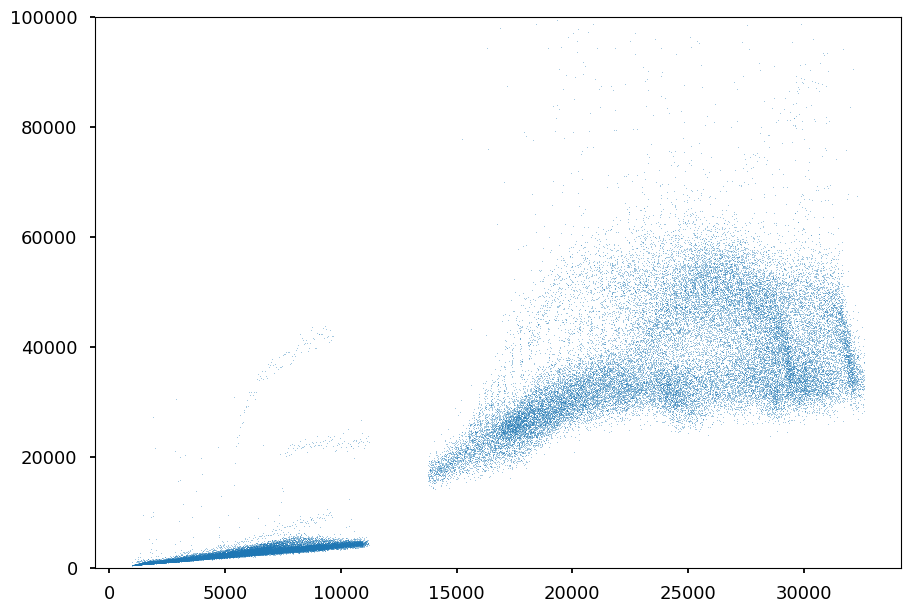

In [4]:
# PTC
from astropy.io import fits
%matplotlib inline
import matplotlib.pyplot as plt

target_dir = "/Users/droryn/work/LVM/data/redux/pixflats"

frames_table = md.get_metadata(tileid="*", mjd=MJD)
frames_table.query("expnum==3120 | expnum==3117", inplace=True)
frames_table.sort_values("camera", inplace=True)
cam_groups = frames_table.groupby("camera")
for cam in cam_groups.groups:    
    cts = []
    var = []
    mflat_path = os.path.join(target_dir, f"lvm-ppixflat-b1-3120.fits")
    with fits.open(mflat_path) as hdul:
        print("Reading :", mflat_path)
        image = hdul[0].data
        mask = hdul[1].data
        image[mask] = np.nan
        sizex, sizey = 10, 40
        for i in range(3,image.shape[0]//sizex - 4):
            for j in range(3,image.shape[1]//sizey - 4):
                cts.append(np.nanmean(image[sizex*i:sizex*(i+1), sizey*j:sizey*(j+1)]))
                var.append(np.nanvar(image[sizex*i:sizex*(i+1), sizey*j:sizey*(j+1)]))

    mflat_path = os.path.join(target_dir, f"lvm-ppixflat-b1-3117.fits")
    with fits.open(mflat_path) as hdul:
        print("Reading :", mflat_path)
        image = hdul[0].data
        mask = hdul[1].data
        image[mask] = np.nan
        sizex, sizey = 10, 40
        for i in range(3,image.shape[0]//sizex - 4):
            for j in range(3,image.shape[1]//sizey - 4):
                cts.append(np.nanmean(image[sizex*i:sizex*(i+1), sizey*j:sizey*(j+1)]))
                var.append(np.nanvar(image[sizex*i:sizex*(i+1), sizey*j:sizey*(j+1)]))

    plt.scatter(cts, var, marker='.', s=0.1)
    plt.ylim(0,1e5)
    plt.show()
    break


